## Loss prediction for Active Learning for DETR TB Bacilli Detection

This notebook is used to predict the loss of our trained DETR model for the next iteration of active learning.

The loss is predicted using a Neural Network that takes as input the features of the current model from different modules of the DETR model and outputs the (predicted) loss.

We make experiments with different combinations of features and also include other ML loss-prediction models (e.g. Random Forest, Linear Regression) for comparison.

Advantages of predicting the loss of the model for active learning:

- The loss of a NN encodes information about the model's performance on the training data. Therefore, the loss can be used as a proxy for the model's performance on the test data. This is useful for active learning since we want to select the images that will improve the model's performance on the test data.
- We can predict the loss of the model for the next iteration of active learning and select the images with the highest loss for annotation.
- While the learned loss-prediction model is model-specific, the same method can be used for any DNN-based architecture (e.g. Faster R-CNN, YOLO, etc.) since they are all based in computing the loss of the model with respect to an image.
- Since the loss-prediction model is trained on the features of the model, it can be used to predict the loss of the model for any dataset (e.g. different datasets of TB images, different datasets of images of other diseases, etc.).
- We can also include non-annotated images in the training of the loss-prediction model, which makes it more useful than other methods that only use the annotated images for training.
- The loss-prediction model can be made lightweight when we don't include all the features of the model. This makes it more efficient than other methods (i.e. those based on uncertainty sampling) that require to compute the loss of the model for all the images in the dataset, which is very useful when we have a very large amount of unlabeled samples but low computational resources.

Also importantly:

- Rather than sampling individual image by predicting their loss, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is very useful when we operate with models that are trained (or pre-trained) with a relatively large batch size. CNNs for example, are usually trained with a batch size of 32 or 64 images. Therefore, these models tend to not learn based on individual images but on batches of images. Therefore, the uncertainty of the model for a single image is not very informative, nor useful in an active learning setting (Note: you should try to confirm this empirically). However, the loss of the model for a batch of images is more informative (Incude experiments using different batch sizes to confirm this empirically). Therefore, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is more informative than sampling individual images and predicting their loss.

Disadvantages of predicting the loss of the model for active learning:

- The loss of the model is not a perfect proxy for the model's performance on the test data. Therefore, the images with the highest loss might not be the best images to annotate.
- The loss-prediction model is model-specific and might not be useful for other models (e.g. Faster R-CNN, YOLO, etc.). Thus, it requires higher initial computational cost to train the loss-prediction model (but might be more efficient in the long run since afterwards it is not necessary to make inference on the model for all samples).

Method based on the paper: [Learning Loss for Active Learning](https://arxiv.org/pdf/1905.03677.pdf)

In [155]:
# imports and setup
import os, dotenv, sys
from pathlib import Path

# data management
from annotations.object_detection.dataset import DatasetForObjectDetection, ImageForObjectDetection
from annotations.object_detection.rect import Rect
from bacili_detection.detr.datasets.tb_bacillus import TBBacilliDataset, make_ds_transforms
from annotations import db
from sqlalchemy import func
import pandas as pd
import json

# pytoch / scientific computing
from torch.utils.data import DataLoader
import numpy as np
import torch

# model specfic functions
from bacili_detection.detr.models import detr_inference
from bacili_detection.detr import util as detr_util

# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

# config
dotenv.load_dotenv()
session = db.get_session(os.getenv("DATABASE_URI"))
sys.path.append('bacili_detection/detr') # add detr to path

In [ ]:
session.rollback()

In [42]:
# 1. load dataset of "unlabeled" data
# "unlabeled" images are those without tags in the database
artifacts = session.query(db.Artifact)\
    .join(db.Project)\
    .join(db.ArtifactTag, isouter=True)\
    .where(db.Project.name == "Bacilli Detection")\
    .group_by(db.Artifact.id)\
    .having(func.count(db.ArtifactTag.id) == 0)\
    .all()
print(f"Found {len(artifacts)} unlabeled images")

transforms = make_ds_transforms('test', includes_target=False)
dataset = TBBacilliDataset(artifacts, transform=transforms, train=False)

Found 960 unlabeled images


In [63]:
# 2. load model
# load the model from checkpoint
checkpoint_path = 'bacili_detection/detr/outputs/checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=False, num_classes=2)
model.load_state_dict(checkpoint['model'])
print("checkpoint loaded at epoch", checkpoint['epoch'])
model.eval();

Using cache found in /Users/simon/.cache/torch/hub/facebookresearch_detr_main
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


checkpoint loaded at epoch 14


/var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/ipykernel_4792/4174211365.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


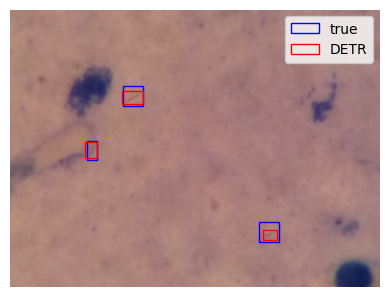

In [64]:
# see how the model performs on a single image
image = dataset._images[0]
boxes = detr_inference([image.pil()], model,  transform=transforms, labels=False)
boxes = [Rect.from_bbox(box, bbox_format='xyxy') for box in boxes[0]]
fig, ax = plt.subplots(1, figsize=(4, 4))
image.display(color='blue', ax=ax, label='true')
for i, box in enumerate(boxes):
    box.plot(ax=ax, color='red', label='DETR' if i == 0 else None)
ax.legend()
fig.show()

In [79]:
# 3. load the dataset of images and annotations that we will use to train the loss prediction model
# i.e same images and annotations that we used to train the DETR model (train, val, test splits)
tr_dataset = TBBacilliDataset(['train', 'test', 'val'], transform=make_ds_transforms('val', includes_target=True))
print(f"Found {len(tr_dataset)} images")

Found 301 images


In [154]:
#  4. We now need to get the losses for each image in the training set to use as our target variable

# 4.1. get the losses for each image in the training set
from bacili_detection.detr.util.misc import get_args_parser, collate_fn
from bacili_detection.detr.util.losses import build_criterion, compute_losses

batch_size = 1
stop_at = None # for testing purposes, stop after this many images

args = get_args_parser().parse_args([]) # get the default arguments
criterion = build_criterion(args) # build the criterion
dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
losses_dict = compute_losses(model, criterion, dataloader, device='cpu', notebook=True, stop_at=stop_at)

  0%|          | 0/301 [00:00<?, ?it/s]

In [170]:
# save the losses to a json file
save_file = f'bacili_detection/active_learning/losses/detr_losses-bs{batch_size}.json'
Path(save_file).parent.mkdir(parents=True, exist_ok=True)
json.dump(losses_dict, open(save_file, 'w'))
df = pd.DataFrame.from_dict(losses_dict, orient='index')
df = pd.concat([df.drop(columns=['loss_dict']), df.loss_dict.apply(pd.Series)], axis=1)\
    .assign(
        tags=lambda df: df.image_ids.apply(lambda l: {t.tag for i in l for t in tr_dataset._images[i].artifact.tags}),
    )
df.sort_values('loss', ascending=False).head()

,image_ids,image_db_ids,loss,loss_ce,loss_bbox,loss_giou,tags
9,[9],[12],2.349391,0.066994,0.145412,0.777669,{test}
79,[79],[306],1.706157,0.554367,0.030088,0.500675,{val}
85,[85],[330],1.660114,0.501754,0.036807,0.487162,{test}
204,[204],[875],1.624580,0.492299,0.030962,0.488737,{test}
1,[1],[3],1.600451,0.030222,0.060908,0.632844,{train}


Image(s) with highest loss ([9]):


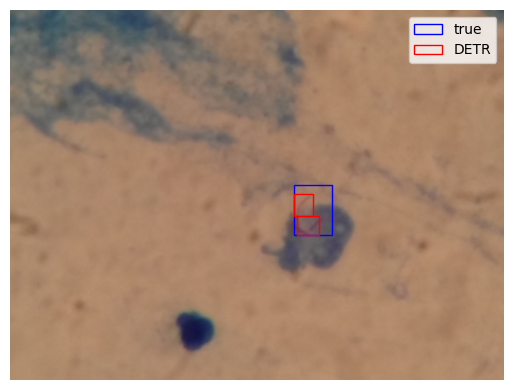

In [177]:
# which image(s) corresponds to the highest loss?
image_ids_highest = df.sort_values('loss', ascending=False).image_ids.iloc[0]
images = [tr_dataset._images[i] for i in image_ids_highest]
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
axes = [axes] if len(images) == 1 else axes
pred_boxes = detr_inference([im.pil() for im in images], model,  transform=transforms, labels=False)
for i, image in enumerate(images):
    image.display(color='blue', ax=axes[i], label='true')
    for j, box in enumerate(pred_boxes[i]):
        box = Rect.from_bbox(box, bbox_format='xyxy')
        box.plot(ax=axes[i], color='red', label='DETR' if j == 0 else None)
    axes[i].legend()
print(f'Image(s) with highest loss ({image_ids_highest}):')
fig.tight_layout()